# Implementing a deep neural network using tensorflow
In this notebok i will implement a 3 hidden layer neural network and feed in all the neccesary data. We will be focused on using S1_A1_E1.mat which means we are only concerned with one subject.

## 1. Import all the neccesary packages

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import scipy
import scipy.io as sio
import time


%matplotlib inline

## 2. Load the data from .mat file and split it into a training (70%) and test (30%) data.

In [2]:
def load_dataset():
    #Load the emg data
    XData = sio.loadmat('emgShuffled.mat')
    X_orig = (np.array((XData['emgShuffled']))).T
    X_train_orig = X_orig[:,0:int(0.7*X_orig.shape[1])]
    X_test_orig = X_orig[:,int(0.7*X_orig.shape[1])+1::]
    #Flatten the EMG data
    X_train_orig = X_train_orig/np.amax(X_train_orig)
    X_test_orig = X_test_orig/np.amax(X_test_orig)
    #Load the labels
    YData = sio.loadmat('yShuffled.mat')
    Y_orig = (np.array((YData['yShuffled']))).T
    Y_train_orig = Y_orig[:,0:int(0.7*Y_orig.shape[1])]
    Y_test_orig = Y_orig[:,int(0.7*Y_orig.shape[1])+1::]
    return X_train_orig, Y_train_orig, X_test_orig, Y_test_orig

## 3. Load the data using the function above and check the dimensions

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()
print ("number of training examples = " + str(X_train_orig.shape[1]))
print ("number of test examples = " + str(X_test_orig.shape[1]))
print ("X_train shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train_orig.shape))
print ("X_test shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test_orig.shape))
print ("number of classes: "+str(int(max(Y_train_orig.T)+1)))

number of training examples = 70709
number of test examples = 30304
X_train shape: (10, 70709)
Y_train shape: (1, 70709)
X_test shape: (10, 30304)
Y_test shape: (1, 30304)
number of classes: 13


## 4. Couple of functions that are needed for the implementation, and do not need much explaining

In [4]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    """
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)

    return A


def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [10, 1])
    
    z3 = forward_propagation(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_with_numpy(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = np.dot(W1, X) + b1                      # Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)                                    # A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2                   # Z2 = np.dot(W2, a1) + b2
    A2 = relu(Z2)                                    # A2 = relu(Z2)
    Z3 = np.dot(W3,A2) + b3                     # Z3 = np.dot(W3,A2) + b3
    
    return Z3

## 5. Convert all the labels to one-hot vector and flatten the EMG values AND SAY HOW MANY CLASSES SUPER IMPORTANT

In [5]:
no_of_classes = 13
Y_train = convert_to_one_hot(Y_train_orig, no_of_classes)
Y_test = convert_to_one_hot(Y_test_orig, no_of_classes)
# Normalize EMG vectors
X_train = X_train_orig
X_test = X_test_orig

print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

Y_train shape: (13, 70709)
Y_test shape: (13, 30304)


## 6. Create Placeholders
Create placeholders for `X` and `Y`. This will allow you to later pass your training data in when you run your session.

In [26]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, shape = [n_x, None])
    Y = tf.placeholder(tf.float32,shape = [n_y, None])
    ### END CODE HERE ###
    
    return X, Y

In [27]:
X, Y = create_placeholders(10, no_of_classes)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_8:0", shape=(10, ?), dtype=float32)
Y = Tensor("Placeholder_9:0", shape=(13, ?), dtype=float32)


## 7. Initialise the paremeters

In [30]:
def initialize_parameters(no_of_classes):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 10]
                        b1 : [25, 1]
                        W2 : [18, 25]
                        b2 : 18, 1]
                        W3 : [no_of_classes, 12]
                        b3 : [no_of_classes, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
            
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [64,10], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [64,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [32, 64], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [32, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [no_of_classes, 32], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [no_of_classes, 1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [31]:
tf.reset_default_graph()

with tf.Session() as sess:
    parameters = initialize_parameters(no_of_classes)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print("W2 = " + str(parameters["W3"]))
    print("b2 = " + str(parameters["b3"]))

W1 = <tf.Variable 'W1:0' shape=(64, 10) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(64, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(32, 64) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(32, 1) dtype=float32_ref>
W2 = <tf.Variable 'W3:0' shape=(13, 32) dtype=float32_ref>
b2 = <tf.Variable 'b3:0' shape=(13, 1) dtype=float32_ref>


## 8. Forward propagation in tensorflow 

Now we will implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. The functions you will be using are: 

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation

In [32]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X), b1)                                             # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)                                              # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [33]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(10, no_of_classes)
    parameters = initialize_parameters(no_of_classes)
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(13, ?), dtype=float32)


## 9. Compute cost

it is very easy to compute the cost using:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```

In [12]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(10, no_of_classes)
    parameters = initialize_parameters(no_of_classes)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


## 10. Backward propagation & parameter updates
Create an "`optimizer`" object. Call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.
For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```
To make the optimization you would do:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

This computes the backpropagation by passing through the tensorflow graph in the reverse order. From cost to inputs.

# Build the model

In [34]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(no_of_classes)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
   
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
   
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters, Z3, Y

Cost after epoch 0: 1.594101
Cost after epoch 100: 0.503260
Cost after epoch 200: 0.454697
Cost after epoch 300: 0.428638
Cost after epoch 400: 0.412606


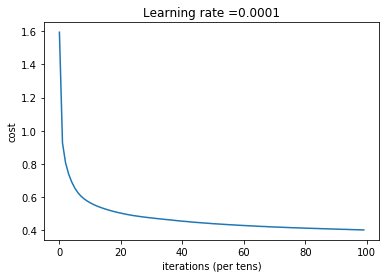

Parameters have been trained!
('Train Accuracy:', 0.88448429)
('Test Accuracy:', 0.88186377)


In [35]:
parameters, Z3, Y = model(X_train, Y_train, X_test, Y_test)

# Obtain the accuracies per each class

## Training Set

In [24]:
Z3_train = forward_propagation_with_numpy(X_train, parameters)

a = tf.placeholder(tf.float32,shape = [X_train.shape[1],])
b = tf.placeholder(tf.float32,shape = [X_train.shape[1],])

c = tf.confusion_matrix(labels = a, predictions = b)

with tf.Session() as sess:
    confusion_matrix = c.eval(feed_dict={a:sess.run(tf.argmax(Y_train)),b:sess.run(tf.argmax(Z3_train))})
    print(np.true_divide(confusion_matrix.diagonal(), np.sum(confusion_matrix, axis = 0)))

[ 0.90451573  0.86009934  0.92870313  0.74057103  0.94637922  0.8837389
  0.84478673  0.93223335  0.82086407  0.78182905  0.89526814  0.73891318
  0.8158363 ]


## Test Set

In [25]:
Z3_test = forward_propagation_with_numpy(X_test, parameters)

a = tf.placeholder(tf.float32,shape = [X_test.shape[1],])
b = tf.placeholder(tf.float32,shape = [X_test.shape[1],])

c = tf.confusion_matrix(labels = a, predictions = b)

with tf.Session() as sess:
    confusion_matrix = c.eval(feed_dict={a:sess.run(tf.argmax(Y_test)),b:sess.run(tf.argmax(Z3_test))})
    print(np.true_divide(confusion_matrix.diagonal(), np.sum(confusion_matrix, axis = 0)))

[ 0.90409697  0.85632731  0.92784993  0.70475396  0.94498778  0.88384755
  0.85358712  0.92634561  0.83529412  0.78313253  0.88986784  0.7073509
  0.81676413]
